In [1]:
include("../src.jl")

rk23

# Адаптивные методы

Анализ большинства методов предполагает фиксированный шаг интегрирования $\tau$, поэтому и поведение методов предсказывается локально. Однако, мы уже сталкивались с проблемами ({numref}`%s Адаптивное интегрирование <chapter_integration_adaptive>`), в которых локальное поведение сильно отличается. Для решения ОДУ также существуют методы, подстраивающие шаг интегрирования в зависимости от локального поведения решения.

В данном разделе мы рассмотрим пример адаптивного алгоритма на основе методов Рунге-Кутта.

## Выбор шага интегрирования

Пусть мы решаем уравнение начиная с $y_i$. Используем два разных метода, пусть у первого метода порядок аппроксимации $p$, а у второго $p+1$. Тогда при интегрировании на $\tau$ мы получим два приближения $y^{(p)}_{i+1}$ и $y^{(p+1)}_{i+1}$. Мы ожидаем, что второе приближение намного точнее первого, поэтому возьмём их разницу за оценку погрешности первого метода 

```{math}
E_i(\tau) = |u_i - y^{(p)}_{i+1}| \approx |y^{(p+1)}_{i+1} - y^{(p)}_{i+1}|.
```

Теперь потребуем, чтобы ошибка при интегрировании была меньше заданной пользователем $\epsilon$. При $\tau \to 0$ погрешность имеет вид $E_i(\tau) \approx C \tau^{p+1}$. Если бы мы использовали вместо $\tau$ шаг $q \tau$, $q > 0$, тогда ошибка бы составила

```{math}
E_i(q\tau) \approx C q^{p+1} \tau^{p+1}.
```

Отсюда следует оценка для подбора $q$, задающего новую сетку.

```{math}
\epsilon = E_i(q \tau) \approx C q^{p+1} \tau^{p+1} \approx E_i(\tau) q^{p+1},
```

откуда

```{math}
:label: ode_adaptive_q_choice

q \approx \bigg(\frac{\epsilon}{E_i(\tau)}\bigg)^{1/(p+1)}.
```

Заметим также, что $q$ может быть как меньше $1$ (требуется шаг мельче), так и больше 1 (можно увеличить шаг). Во втором случае $q$ следует ограничивать сверху, иначе можно проскочить участки, где требуется мелкий шаг.

Теперь можно составить алгоритм решения.

(ode_adaptive_algo_outline)=
```{proof:algorithm} Адаптивное решение ОДУ
Пусть известно приближение решения $y_i$ в $t = t_i$ и шаг интегрирования $\tau$

1. Подсчитать два приближения решения $y^{(p)}_{i+1}$, $y^{(p+1)}_{i+1}$ и оценить ошибку.
2. Если ошибка мала (меньше заданной пользователем), то принять в качестве решения в $t=t_i + \tau$ $y_{i+1} = y^{(p+1)}_{i+1}$.
3. Подстроить шаг $\tau$, заменив на $q\tau$ {eq}`ode_adaptive_q_choice`.
4. Повторять, пока $t$ не достигнет $T$.
```

## Встроенные формулы

Допустим, мы будем использовать методы Рунге-Кутты второго и третьего порядков. Вообще говоря, нам может понадобится до 5 вычислений функции $f(t, u)$, поскольку точки, в которых происходит вычисление могут не совпадать. Пять вычислений уже вдвое больше, чем для двухэтапного метода.

Поскольку методы Рунге-Кутты являются параметрическими семействами, то выведены пары методов, использующие общие точки для вычисления $f(t, u)$. Их называют **встроенными методами Рунге-Кутта** (*embedded Runge-Kutta*). За счёт этого свойства, встроенные методы экономят количество вычислений.

```{margin}
Метод Богацкого-Шампина можно встретить под именем РК23.
```
В качестве примера мы воспользуемся методом **Богацкого-Шампина** (*Bogacki–Shampine*), являющимся встроенным методом Рунге-Кутты и пользующимся приближениями второго и третьего порядков. Его таблица Бутчера имеет вид

```{math}
\begin{array}{r|cccc}
0 & & & & \\
\frac{1}{2} & \frac{1}{2} & & & \\
\frac{3}{4} & 0 & \frac{3}{4} & & \\
1 & \frac{2}{9} & \frac{1}{3} & \frac{4}{9} & \\
\hline
 & \frac{2}{9} & \frac{1}{3} & \frac{4}{9} & 0 \\
\hline
 & \frac{7}{24} & \frac{1}{4} & \frac{1}{3} & \frac{1}{8}
\end{array}
```

Верхняя часть таблицы по-прежнему задаёт коэффициенты $a_s$ и $b_{sj}$, для обоих методов они одинаковые. Отличаются же методы весами $\sigma_s$. Первая строка нижней части таблицы задаёт $\sigma^{(2)}_s$ веса для метода второго порядка, а вторая строка (она же последняя) задаёт веса $\sigma^{(3)}_s$ для метода третьего порядка.

Предоставим также явный вид метода

```{math}
\begin{split}
k_1 &= f(t_i, y_i),\\
k_2 &= f\Big(t_i + \frac{1}{2}\tau, y_i + \frac{1}{2}\tau k_1\Big),\\
k_3 &= f\Big(t_i + \frac{3}{4}\tau, y_i + \frac{3}{4}\tau k_2\Big),\\
y^{(2)}_{i+1} &= y_i + \frac{2}{9}\tau k_1 +  \frac{1}{3}\tau k_2 +  \frac{4}{9}\tau k_3,\\
k_4 &= f(t_i + \tau, y^{(2)}_{i+1}),\\
y^{(3)}_{i+1} &= y_i + \frac{7}{24}\tau k_1 + \frac{1}{4}\tau k_2 + \frac{1}{3}\tau k_3 + \frac{1}{8}\tau k_4.
\end{split}
```

Заметьте, что если в качестве $y_{i+1}$ брать второе приближение $y^{(2)}_{i+1}$ на шаге 2 {numref}`Алгоритма %s <ode_adaptive_algo_outline>`, то $k_4$ равняется $k_1$ на итерации $i+1$.
Данное свойство называют *first same as last* (FSAL). Это позволяет уменьшить количество вычислений $f(t, u)$, и в итоге получаем одно вычисление при инициализации алгоритма и по три вычисления за шаг.

Наиболее популярным является [метод Дорманда-Принса](https://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method) (*Dormand-Prince*), использующий методы Рунге-Кутты четвёртого и пятого порядка аппроксимации и ту же идею для оценки ошибки.

## Реализация

```{proof:function} rk23

**Метод Богацкого-Шампина**

:::julia
"""
    rk23(problem; tol[, maxsteps, maxadjuststeps])

Решает задачу Коши `problem` адаптивным методом Богацкого-Шампина.
Погрешность вычислений задаётся `tol`, а максимальное количество шагов
интегрирования `maxsteps`. Число шагов, разрешённое для адаптации шага `maxadjuststeps`.
"""
function rk23(problem::CauchyODEProblem;
    tol::Real,
    maxsteps::Integer=10000,
    maxadjuststeps::Integer=20,
)
    t₀, T = problem.bound
    trange = [t₀]
    u = [problem.u₀]
    k₁ = problem.f(t₀, problem.u₀)
    τ = 0.5 * tol^(1/3)

    for i in 1:maxsteps
        tᵢ, uᵢ = trange[i], u[i]
        
        tᵢ == T && break
        
        if tᵢ + τ == tᵢ
            @warn "Достигнут предел машинной точности по τ"
            break
        end

        for j in 1:maxadjuststeps
            k₂ = problem.f(tᵢ + τ/2, uᵢ + τ*k₁/2)
            k₃ = problem.f(tᵢ + 3τ/4, uᵢ + 3τ*k₂/4)
            unew2 = uᵢ + τ*(2k₁ + 3k₂ + 4k₃)/9  # РК2 приближение
            k₄ = problem.f(tᵢ + τ, unew2)

            Δ = τ * (-5k₁/72 + k₂/12 + k₃/9 - k₄/8)  # разница РК2 и РК3 приближений
            err = norm(Δ, Inf)
            maxerr = tol * (1 + norm(uᵢ, Inf))

            accepted = err < maxerr
            if accepted
                push!(trange, tᵢ + τ)
                push!(u, unew2)
                k₁ = k₄  # FSAL: k₄ = f(tᵢ + τ, uᵢ₊₁) == new k₁
            end
            
            # подбор нового шага
            q = 0.8 * (maxerr/err)^(1/3)    # оценка шага из погрешности
            q = min(q, 4.0)                 # ограничиваем максимальное увеличение
            τ = min(q*τ, T - trange[end])   # не выходим за предел T

            accepted && break
            
            j == maxadjuststeps && error("Число шагов по подбору τ превышено.")
        end
        
        i == maxsteps && @warn "Число шагов превышено, конечное время не достигнуто"
    end
    return trange, u
end
:::
```

```{proof:demo}
```
```{raw} html
<div class="demo">
```

Ниже представлен пример решения задачи Коши

```{math}
\begin{split}
u' &= e^{t - u \sin u}, \quad t \in (0, 5],\\
u(0) &= 0.
\end{split}
```

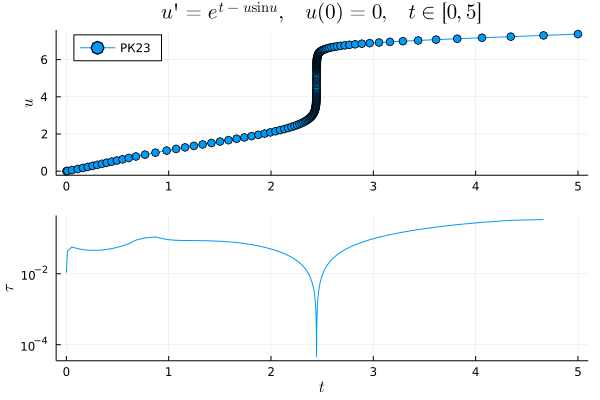

In [2]:
problem = CauchyODEProblem(
    f=(t, u) -> exp(t - u*sin(u)),
    tstart=0,
    tend=5,
    u₀=0,
)
plt = plot(;
    title=L"u' = e^{t - u \sin{u}},\quad u(0) = 0,\quad t\in [0, 5]",
    leg=:topleft,
    layout=(2,1),
)
t, u = rk23(problem; tol=1e-5, maxsteps=1000)
plot!(t, u; label="РК23", marker=:o, subplot=1, ylabel=L"u", xlim=(-0.1, 5.1))
plot!(t[1:end-1], diff(t);
    subplot=2,
    title="",
    yaxis=(:log10, L"\tau"),
    label="",
    xlabel=L"t",
    xlim=(-0.1, 5.1),
)
plt

```{raw} html
</div>
```